In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import re

In [3]:
# 温度曲线绘制函数
def tem_curve(data):
    """温度曲线绘制"""
    date = list(data['日期'])
    
    def clean_numeric_column(column):
        """清理列中的非数字字符"""
        cleaned = []
        for value in column:
            if isinstance(value, str):
                # 使用正则表达式提取数字部分
                match = re.search(r'[-+]?\d*\.\d+|[-+]?\d+', value)
                if match:
                    cleaned.append(match.group())
                else:
                    cleaned.append(np.nan)
            else:
                cleaned.append(value)
        return pd.to_numeric(cleaned, errors='coerce')

    # 清理并转换最低气温和最高气温数据
    tem_low = clean_numeric_column(data['最低气温']).tolist()
    tem_high = clean_numeric_column(data['最高气温']).tolist()

    # 打印部分数据检查类型
    print("tem_low 前 5 个元素:", tem_low[:5])
    print("tem_high 前 5 个元素:", tem_high[:5])

    num_days = len(date)  # 获取数据的天数

    # 处理 date 列表，确保元素为字符串
    for i in range(len(date)):
        if not isinstance(date[i], str):
            date[i] = str(date[i])

    # 处理缺失值
    for i in range(num_days):
        # 处理最低气温缺失或异常
        if not math.isfinite(tem_low[i]):
            tem_low[i] = tem_low[i - 1] if i > 0 else np.nanmean(tem_low)  
        # 处理最高气温缺失或异常
        if not math.isfinite(tem_high[i]):
            tem_high[i] = tem_high[i - 1] if i > 0 else np.nanmean(tem_high)  

    tem_high_ave = sum(tem_high) / num_days  # 求平均高温
    tem_low_ave = sum(tem_low) / num_days  # 求平均低温

    tem_max = max(tem_high)
    tem_max_date_idx = tem_high.index(tem_max)  # 求最高温对应日期索引
    tem_min = min(tem_low)
    tem_min_date_idx = tem_low.index(tem_min)  # 求最低温对应日期索引

    x = range(1, num_days + 1)  # 动态生成 x 轴
    plt.figure(1)
    plt.plot(x, tem_high, color='red', label='高温')  # 画出高温度曲线
    plt.scatter(x, tem_high, color='red')  # 点出每个时刻的温度点
    plt.plot(x, tem_low, color='blue', label='低温')  # 画出低温度曲线
    plt.scatter(x, tem_low, color='blue')  # 点出每个时刻的温度点

    # 画出平均温度虚线
    plt.plot([1, num_days + 1], [tem_high_ave, tem_high_ave], c='black', linestyle='--', label='平均高温')  
    plt.plot([1, num_days + 1], [tem_low_ave, tem_low_ave], c='black', linestyle='--', label='平均低温')  

    plt.legend()
    # 标出最高温度
    plt.text(tem_max_date_idx + 1 + 0.15, tem_max + 0.15, str(tem_max), ha='center', va='bottom', fontsize=10.5)  
    # 标出最低温度
    plt.text(tem_min_date_idx + 1 + 0.15, tem_min + 0.15, str(tem_min), ha='center', va='bottom', fontsize=10.5)  
    plt.title('未来14天高温低温变化线图')
    plt.xticks(x, date, rotation=45)  # 用真实日期作为x轴刻度，并旋转45度避免重叠
    plt.xlabel('日期')
    plt.ylabel('摄氏度/℃')
    plt.show()

In [4]:
# 风向转换函数
def change_wind(wind):
    """转换风向"""
    wind_mapping = {
        "北风": 90,
        "南风": 270,
        "西风": 180,
        "东风": 360,
        "东北风": 45,
        "西北风": 135,
        "西南风": 225,
        "东南风": 315
    }
    converted_wind = []
    for w in wind:
        # 处理未识别的风向，设为 NaN
        converted_wind.append(wind_mapping.get(w, np.nan))
    return converted_wind

In [5]:
# 风向雷达图函数
def wind_radar(data):
    """风向雷达图"""
    wind1 = list(data['风向1'])
    wind2 = list(data['风向2'])
    # 将风级列转换为数值类型，无法转换的设为 NaN
    wind_speed = pd.to_numeric(data['风级'], errors='coerce').tolist()
    wind1 = change_wind(wind1)
    wind2 = change_wind(wind2)

    degs = np.arange(45, 360 + 45, 45)  
    temp = []
    for deg in degs:
        speed = []
        for i in range(len(wind1)):
            if np.isfinite(wind1[i]) and (deg - 22.5) <= wind1[i] < (deg + 22.5):
                speed.append(wind_speed[i])
            elif np.isfinite(wind1[i]) and (deg - 22.5 + 360) <= wind1[i] < (deg + 22.5 + 360):
                speed.append(wind_speed[i])
            if np.isfinite(wind2[i]) and (deg - 22.5) <= wind2[i] < (deg + 22.5):
                speed.append(wind_speed[i])
            elif np.isfinite(wind2[i]) and (deg - 22.5 + 360) <= wind2[i] < (deg + 22.5 + 360):
                speed.append(wind_speed[i])
        # 过滤掉 NaN 值
        valid_speed = [s for s in speed if not np.isnan(s)]
        if valid_speed:
            temp.append(sum(valid_speed) / len(valid_speed))
        else:
            temp.append(0)
    print(temp)
    N = 8
    theta = np.arange(0 + np.pi / 8, 2 * np.pi + np.pi / 8, 2 * np.pi / 8)
    radii = np.array(temp)

    # 强化对 radii 数组的检查
    if len(radii) == 0 or np.all(radii == 0):
        print("没有有效的风速数据，无法绘制风玫瑰图。")
        return

    # 确保 radii 数组的有效性
    if not np.isfinite(radii).all():
        print("风速数据包含无效值，无法绘制风玫瑰图。")
        return

    plt.axes(polar=True)
    max_radii = max(radii) if radii.any() else 1e-6
    colors = [(1 - x / max_radii, 1 - x / max_radii, 0.5) for x in radii]
    plt.bar(theta, radii, width=2 * np.pi / N, bottom=0.0, color=colors)
    plt.title('未来14天风玫瑰图', x=0.2, fontsize=20)
    plt.show()

In [6]:
# 天气饼图函数
def weather_pie(data):
    """绘制天气饼图"""
    if '天气' not in data.columns:
        print("数据中缺少 '天气' 列，无法绘制饼图。")
        return
    weather = list(data['天气'])
    dic_weather = {}
    for wea in weather:  
        if wea in dic_weather:
            dic_weather[wea] += 1
        else:
            dic_weather[wea] = 1
    print(dic_weather)

    # 检查 dic_weather 是否为空
    if not dic_weather:
        print("没有可用的天气数据，无法绘制饼图。")
        return

    explode = [0.01] * len(dic_weather.keys())
    color = ['lightskyblue','silver','yellow','salmon','grey','lime','gold','red','green','pink']  
    plt.pie(dic_weather.values(), explode=explode, labels=dic_weather.keys(), 
            autopct='%1.1f%%', colors=color)
    plt.title('未来14天天气分布图')
    plt.show()

In [7]:
def main():
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    # 先尝试使用 GB2312 编码读取文件
    data14 = pd.read_csv('weather_14days.csv', encoding='utf-8')

    # 打印各列的数据类型
    print(data14.dtypes)
    tem_curve(data14)
    wind_radar(data14)
    weather_pie(data14)

日期      object
天气      object
最低气温     int64
最高气温     int64
风向1     object
风向2     object
风级       int64
dtype: object
tem_low 前 5 个元素: [26, 26, 26, 26, 27]
tem_high 前 5 个元素: [3, 2, 2, 3, 3]


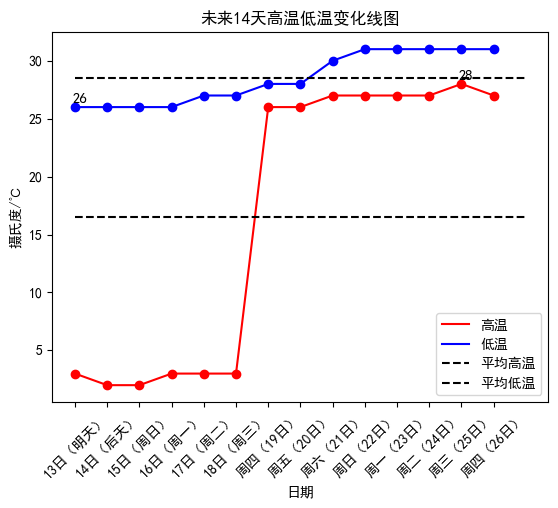

[0, 0, 0, 0, 3.0, 3.923076923076923, 3.3333333333333335, 0]


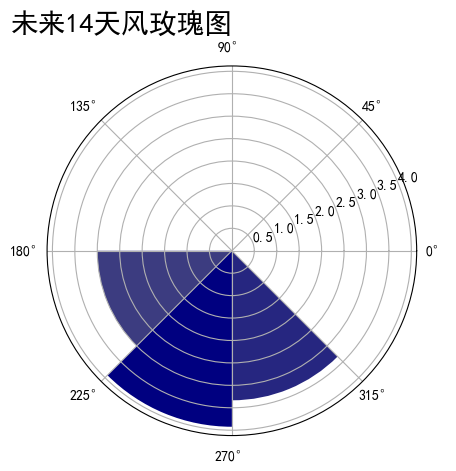

{'中雨转大雨': 1, '大雨转中雨': 1, '阵雨': 3, '阴转中雨': 1, '雨': 8}


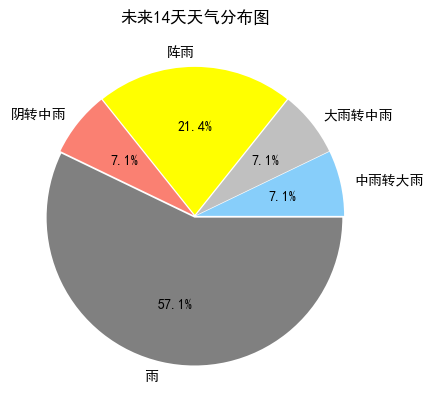

In [8]:
if __name__ == '__main__':
    main()